In [1]:
from pyspark.sql import SparkSession
import os 
import json 
import re
import pandas as pd 
import numpy as np
import time 

In [4]:
spark = (
    SparkSession.builder.master("local[*]")
    .appName("PySpark JSON Nested Example")
    # .config("spark.executor.memory", "8g")
    # .config("spark.driver.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/23 16:08:43 INFO SparkEnv: Registering MapOutputTracker
23/04/23 16:08:43 INFO SparkEnv: Registering BlockManagerMaster
23/04/23 16:08:43 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/04/23 16:08:43 INFO SparkEnv: Registering OutputCommitCoordinator


In [5]:
path = "gs://ncf446-201929129/rdd_data_metadata/" 

In [6]:
bigframe=[] 
for i in range(1, 6, 1): #reading only 5 parquet files
    index = f'batch_{i}'
    fpath = path+index
    bigframe.append(spark.read.parquet(fpath))  
    
metaframe = bigframe[0]
for index, frame in enumerate(bigframe):
    if index>=len(bigframe)-1: #len = 5 index cannot be >5
        break
    else:
        metaframe = metaframe.union(bigframe[index+1]) #merge dataframe
metaframe.show(10)

+-----+---------------+----------+----------+-------------+--------------------+
|  pid|           name|num_tracks|num_albums|num_followers|              tracks|
+-----+---------------+----------+----------+-------------+--------------------+
|10499|          Chill|        26|        24|            1|[{0, Heroin, null...|
|10500|         cardio|       146|       138|            1|[{0, Sweat (A La ...|
|10501|      Acoustic |        38|        38|            1|[{0, Hey - Acoust...|
|10502|        Its lit|        13|        13|            1|[{0, Faith - Radi...|
|10503|         Lounge|       168|       154|            1|[{0, Amazon Dawn,...|
|10504|Play it forward|        31|        29|            1|[{0, The General,...|
|10505|        Country|       116|        86|            2|[{0, Who Are You ...|
|10506|        country|        62|        53|            2|[{0, 19 You + Me,...|
|10507|   Chilllllllll|       106|        95|            2|[{0, Let Her Go, ...|
|10508|          Exit |     

## Some Exploratory Data Analysis

In [7]:
sdf_from_parquet = metaframe

In [8]:
sdf_from_parquet.count() #we only delve into 50000 playlists in our analysis. 

50000

In [9]:
from pyspark.sql.functions import col, explode, count
import matplotlib.pyplot as plt
import pandas as pd 

df = sdf_from_parquet

compute the number of tracks in every playlist and plot the distribution of frequency of the counts. We can observe that most of the playlists have roughly less than 150 tracks. 

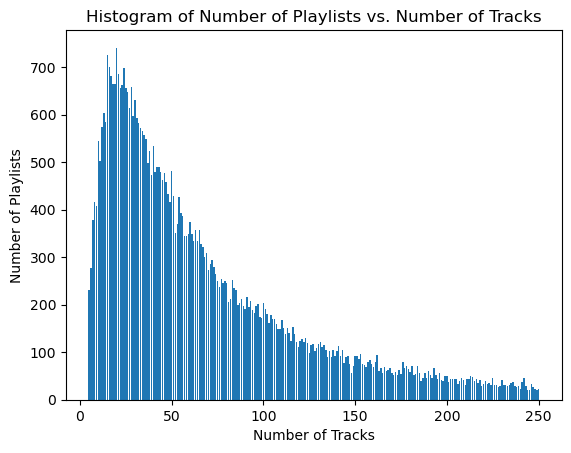

In [10]:
aggcount = df.groupBy("num_tracks").agg(count("pid").alias("num_playlists"))
load = aggcount.collect()
x_values = [row.num_tracks for row in load]
y_values = [row.num_playlists for row in load]
plt.bar(x_values, y_values)
plt.xlabel("Number of Tracks")
plt.ylabel("Number of Playlists")
plt.title("Histogram of Number of Playlists vs. Number of Tracks")
plt.show()

Most of the playlists have less than 150 tracks. 

In [11]:
new_df = df.select(col("tracks")).withColumn("tracks", explode(col("tracks"))).select("tracks.*")
new_df.show(20)

distinct_tracks = new_df.select(col("track_name"), col("track_uri"), col("album_name"), col("album_name"), col("artist_name"), col("artist_uri")).distinct()
print(f'Number of distinct tracks: {distinct_tracks.count()}')

+---+--------------------+------------+--------------------+--------------------+--------------------+--------------+--------------------+
|pos|          track_name|track_artist|           track_uri|          album_name|           album_uri|   artist_name|          artist_uri|
+---+--------------------+------------+--------------------+--------------------+--------------------+--------------+--------------------+
|  0|              Heroin|        null|spotify:track:3qo...|       Lust For Life|spotify:album:1nP...|  Lana Del Rey|spotify:artist:00...|
|  1|Press Play and Es...|        null|spotify:track:1Fp...|Press Play and Es...|spotify:album:0io...|   Teflon Sega|spotify:artist:0J...|
|  2|               Bones|        null|spotify:track:3xS...|            Bones EP|spotify:album:33R...|Dustin Tebbutt|spotify:artist:0z...|
|  3|   Always In My Head|        null|spotify:track:0FM...|       Ghost Stories|spotify:album:2G4...|      Coldplay|spotify:artist:4g...|
|  4|       Spotless Mind| 

Number of distinct tracks: 457016


here we analyse the top songs. One of most naive approaches in music recommendation could be just to recommend the top tracks that most people listen to. Probabilistic speaking, such an approach has a decent chance to yield decent results. But this is not the point of building a recommendation engine. We want to build a more personalised recommendation engine that recommends songs to everyoen based on their preferences. 

In [12]:
count_freq_songs = new_df.groupBy(col("track_name"), col("track_uri"), col("album_name"), col("album_name"), col("artist_name"), col("artist_uri")).agg(count('*').alias("count"))
Ordered_count_freq_songs = count_freq_songs.orderBy(col("count").desc())
Ordered_count_freq_songs.show(20)

+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----+
|          track_name|           track_uri|          album_name|          album_name|      artist_name|          artist_uri|count|
+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----+
|             HUMBLE.|spotify:track:7KX...|               DAMN.|               DAMN.|   Kendrick Lamar|spotify:artist:2Y...| 2301|
|           One Dance|spotify:track:1xz...|               Views|               Views|            Drake|spotify:artist:3T...| 2208|
|Broccoli (feat. L...|spotify:track:7yy...|       Big Baby DRAM|       Big Baby DRAM|             DRAM|spotify:artist:5M...| 2106|
|              Closer|spotify:track:7BK...|              Closer|              Closer| The Chainsmokers|spotify:artist:69...| 2053|
|     Congratulations|spotify:track:3a1...|              Stoney|              Stone

In [13]:
pd_count_table = count_freq_songs.toPandas() 
print(pd_count_table.shape)
pd_count_table.head()

(457016, 7)


,track_name,track_uri,album_name,album_name,artist_name,artist_uri,count
0,I Want Crazy - Encore,spotify:track:4FkgULes13bk2eHrsJg4q9,Hunter Hayes (Encore),Hunter Hayes (Encore),Hunter Hayes,spotify:artist:7H6dkUChT5EoOQtUVMg4cN,459
1,What's Luv? (feat. Ja-Rule & Ashanti) - Featur...,spotify:track:2mKouqwAIdQnMP43zxR89r,Jealous Ones Still Envy (J.O.S.E),Jealous Ones Still Envy (J.O.S.E),Fat Joe,spotify:artist:3ScY9CQxNLQei8Umvpx5g6,226
2,Like The Rain,spotify:track:5rQcDgz44osyj2rdtuOmPl,Greatest Hits,Greatest Hits,Clint Black,spotify:artist:3Ay15wt0QChT4Kapsuw5Jt,42
3,The World's Greatest,spotify:track:3jM2x40f38ny0BZSF1AV8P,Q-music Top 500 Editie 2010,Q-music Top 500 Editie 2010,R. Kelly,spotify:artist:2mxe0TnaNL039ysAj51xPQ,13
4,Bank Rolls - Remix,spotify:track:2IuWB214OCchhPrBK8OtIR,Bank Rolls,Bank Rolls,Tate Kobang,spotify:artist:05ZOzt8hlefGYXWJIL37PI,71


We can see here that the distribution of frequencies top tracks is very skewed. The top tracks received a lot of feedbacks. ie Lot of users like to listen to hits playlist.  

In [14]:
pd_count_table.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
count,457016.0,7.326347,40.437989,1.0,1.0,1.0,3.0,2301.0


In [15]:
pd_count_table_count_100 = pd_count_table[pd_count_table['count'] >= 100]
pd_count_table_count_100.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
count,5480.0,280.022445,232.829248,100.0,133.0,194.0,329.0,2301.0


<AxesSubplot:ylabel='Frequency'>

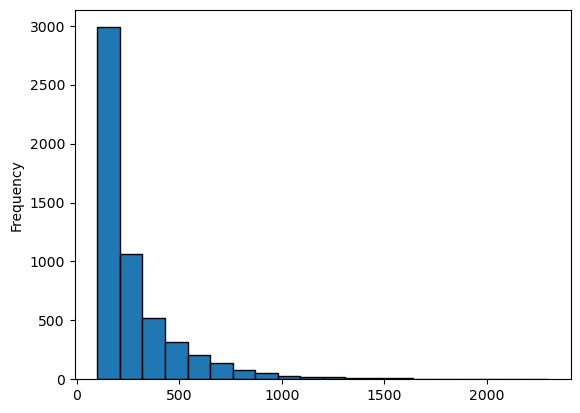

In [16]:
pd_count_table_count_100['count'].plot.hist(bins=20, edgecolor='black')

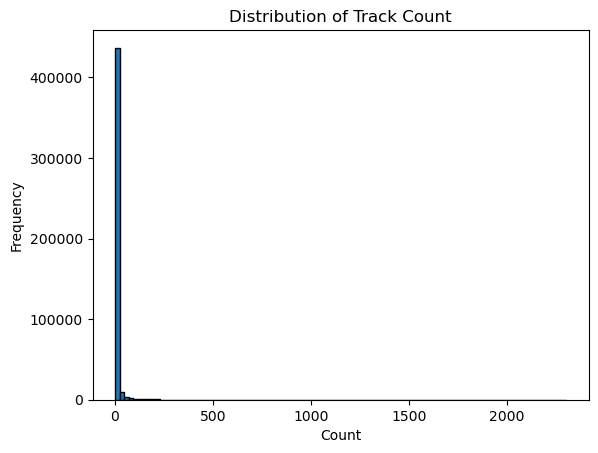

In [17]:
# Create the histogram
pd_count_table['count'].plot.hist(bins=100, edgecolor='black')

# Set the labels and title
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Track Count')

# Show the plot
plt.show()

From the diagram above, we observe that the common track counts in all playlists is very skewedly distributed. Tracks that happen to be in 100-500 playlists are of 0.4% all songs.  

Top 20 artists

+--------------------+--------------------+-----+
|         artist_name|          artist_uri|count|
+--------------------+--------------------+-----+
|               Drake|spotify:artist:3T...|42988|
|          Kanye West|spotify:artist:5K...|20867|
|      Kendrick Lamar|spotify:artist:2Y...|17530|
|             Rihanna|spotify:artist:5p...|16745|
|          The Weeknd|spotify:artist:1X...|15803|
|              Eminem|spotify:artist:7d...|14621|
|          Ed Sheeran|spotify:artist:6e...|13469|
|              Future|spotify:artist:1R...|12980|
|             J. Cole|spotify:artist:6l...|12521|
|             Beyoncé|spotify:artist:6v...|12462|
|       Justin Bieber|spotify:artist:1u...|12244|
|    The Chainsmokers|spotify:artist:69...|11226|
|          Luke Bryan|spotify:artist:0B...|10707|
|         Chris Brown|spotify:artist:7b...|10478|
|Florida Georgia Line|spotify:artist:3b...|10218|
|       Calvin Harris|spotify:artist:7C...|10065|
|        Lil Uzi Vert|spotify:artist:4O...|10000|


<AxesSubplot:ylabel='artist_name'>

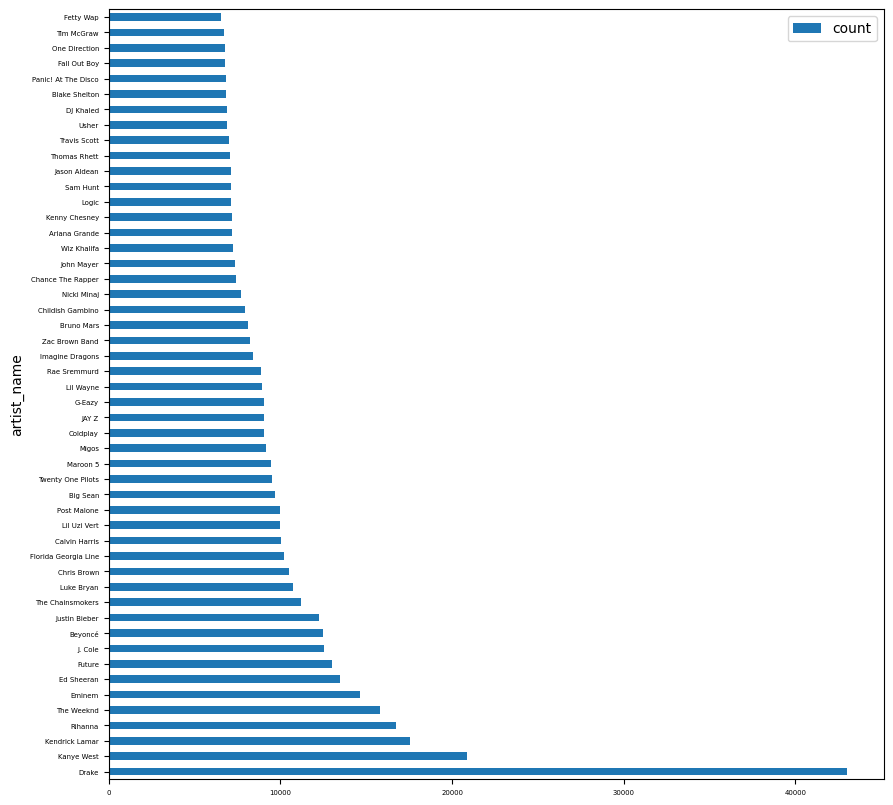

In [18]:
top_artist = new_df.groupBy(col("artist_name"), col("artist_uri")).agg(count('*').alias("count")).orderBy(col("count").desc())
top_artist.show(20)
top_artist_pd = top_artist.toPandas()
top_artist_pdplot = top_artist_pd.iloc[:50, :]
top_artist_pdplot.plot.barh(x='artist_name', y='count', fontsize=5, figsize=(10, 10))